In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
tfd = tfp.distributions

In [2]:
file = 'outputs/pred_matchday_4.xlsx'

In [3]:
db = pd.read_excel(file, index_col = 0)   

In [4]:
db

,role,team,oppteam,home,starter,vote%,MV,MV std,FV,FV std,MV loc,MV scale,MV skewness,MV tailweight,FV loc,FV scale,FV skewness,FV tailweight,Clean Sheet %
player,,,,,,,,,,,,,,,,,,,
Rossi F.,P,Atalanta,Fiorentina,0,0.0,1,6.109952,0.455623,5.139983,0.751770,6.129853,0.545903,-0.026930,1.024186,5.328891,1.142012,-0.122005,1.029078,3.029286
Musso,P,Atalanta,Fiorentina,0,1.0,80,6.026820,0.479838,4.632784,0.883422,6.040918,0.574122,-0.018150,1.038445,5.058631,1.267127,-0.248430,0.992984,1.178538
Carnesecchi,P,Atalanta,Fiorentina,0,0.0,5,5.988562,0.492755,4.077794,1.066340,6.002525,0.589996,-0.017496,1.046207,4.783760,1.400133,-0.389061,0.954299,0.944095
Zappacosta,D,Atalanta,Fiorentina,0,1.0,90,6.083625,0.627924,6.479160,1.053932,5.897724,0.687691,0.197360,0.773252,5.540676,1.267551,0.512369,1.299510,0.000000
Zortea,D,Atalanta,Fiorentina,0,0.0,0,6.150186,0.516681,6.476537,0.757362,6.067196,0.583386,0.104385,0.850812,5.875261,0.978617,0.433943,1.299440,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bonazzoli,A,Verona,Bologna,1,0.4,60,6.194463,0.573160,6.719338,1.030227,5.917695,0.593300,0.338062,0.807901,5.607124,1.010478,0.712825,1.299556,0.000000
Henry,A,Verona,Bologna,1,0.0,0,5.948657,0.576159,6.411596,0.883478,5.582782,0.562697,0.465999,0.808078,5.444796,0.848190,0.732595,1.299526,0.000000
Kallon,A,Verona,Bologna,1,0.0,0,5.984714,0.458801,6.300039,0.708241,5.767212,0.467892,0.336912,0.899963,5.570446,0.741041,0.651962,1.299474,0.000000


In [5]:
def get_player_distributions(player): 
    dist_mv = tfp.distributions.SinhArcsinh(
    db.loc[player, 'MV loc'],
    db.loc[player, 'MV scale'],
    db.loc[player, 'MV skewness'],
    db.loc[player, 'MV tailweight']
    )
    
    dist_fv = tfp.distributions.SinhArcsinh(
    db.loc[player, 'FV loc'],
    db.loc[player, 'FV scale'],
    db.loc[player, 'FV skewness'],
    db.loc[player, 'FV tailweight']
    )
    
    dist_cs = tfp.distributions.Bernoulli(probs = db.loc[player, 'Clean Sheet %']/100)
    
    return [dist_mv, dist_fv, dist_cs];

In [6]:
def simulate_lineup(squad, ITERS = 1000, MOD = False, CS = False, plot = True):
    dist = [None] * len(squad)

    defenders = list([0]) * len(squad)


    for i in range(len(squad)):
        dist[i] = get_player_distributions(squad[i])  

        if(db['role'][squad[i]] == 'D'):
            defenders[i] = 1
            
    total_points = np.zeros(ITERS)
    clean_sheets = np.zeros(ITERS)
    mod_points = np.zeros(ITERS)

    mv_samples = [None] * len(squad)
    fv_samples = [None] * len(squad)

    for i in range(len(squad)):
        mv_samples[i] = dist[i][0].sample(ITERS)
        fv_samples[i] = dist[i][1].sample(ITERS)

    cs_samples = dist[0][2].sample(ITERS)

    for k in range(ITERS):
        d_points = list([0]) * len(squad)

        cleansheet = float(cs_samples[k])
        if(not CS):
            cleansheet = 0;
            
        total_points[k] += cleansheet
        clean_sheets[k] += cleansheet

        for i in range(len(squad)):      
            if(defenders[i] == 1):
                d_points[i] = float(mv_samples[i][k])

            total_points[k] += float(fv_samples[i][k])

        d_points.sort(reverse = True)

        if(MOD and d_points[3] > 0): # minimum 3 defenders to get MOD
            mod_avg = 0
            for j in range(3):
                mod_avg += round(d_points[j] * 2) / 2
            mod_avg /= 3

            if(mod_avg >= 7):
                mod_points[k] = 6
            elif(mod_avg >= 6.5):
                mod_points[k] = 3
            elif(mod_avg >= 6):
                mod_points[k] = 1

        total_points[k] += mod_points[k]
    
    loc_0 = total_points.mean()

    squad_model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(3),
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.SinhArcsinh(loc= loc_0 + t[..., 0], scale = 1e-3 + tf.math.softplus(t[..., 1]), 
                                                        skewness = t[..., 2], tailweight = 0.8) # fixed tailweight seems ok
            )
        ]
    )

    def negloglik(y, distr):
        return -distr.log_prob(y)

    squad_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1), loss=negloglik)

    dummy_input = np.zeros(total_points.shape)[:, np.newaxis]
    squad_model.fit(dummy_input, total_points, epochs=100, verbose=False)
    
    squad_points_dist = squad_model(np.zeros(1)[:, np.newaxis])

    if(plot):

        x = np.arange(start = 0, stop = 200, step = 0.001)
        prb = squad_points_dist.prob(x)

        mn = total_points.mean()
        pot = mn + 2 * total_points.std()

        f, ax = plt.subplots(1, 2)

        ax[0].plot(x, prb)
        ax[0].fill_between(x, prb, color = 'lightblue')
        ax[0].vlines(x = mn, color = 'black', ymin = 0, ymax = 3, linestyle = 'dashed', label = 'mean = ' + "{:.2f}".format(mn))
        ax[0].vlines(x = pot, color = 'grey', ymin = 0, ymax = 3, linestyle = 'dashed', label = 'potential = ' + "{:.2f}".format(pot))

        
        ax[0].set_xlim([40, 140])
        ax[0].set_ylim([0, 0.12])

        ax[0].legend()

        #ax[0].hist(total_points, bins = 20, density = True)


        ax[1].text(0.1, 0.8, "\n".join(squad), fontsize=10, transform=ax[1].transAxes, verticalalignment = 'top')

        text = "\n".join(['Avg Total Points = ' + "{:.2f}".format(total_points.mean()), 
                          'Avg Mod Points = ' + "{:.2f}".format(mod_points.mean()), 
                          'Avg Clean Sheets = ' + "{:.2f}".format(clean_sheets.mean())])

        ax[1].text(0.5, 0.8, text, fontsize=10, transform=ax[1].transAxes, verticalalignment = 'top')

        ax[1].axis('off')



        plt.subplots_adjust(right=1.5)

        plt.show()
    return [squad_model, squad_points_dist, total_points.mean(), mod_points.mean(), clean_sheets.mean()]

In [7]:
def sinh_archsinh_pdf(x, mu, sigma, eps, delta):
    mul = 2 / np.sinh( np.arcsinh(2) * delta)    
    z = (x - mu) / (sigma*mul)            
    S = np.sinh( -eps + (1/delta) * np.arcsinh(z))
    return np.exp(-0.5 * S * S) * np.sqrt(1 + S * S) / ( sigma * mul * delta ) / np.sqrt(1 + z * z) / np.sqrt(2 * np.pi)

def plot_lineup(squad, config):
    fig, axs = plt.subplots(6, 5, figsize=(14, 10))

    i = 0;
    j = 1;

    for ax in axs.flat:
        ax.axis('off')

        if(i < len(config) and config[i] == j):
            player = squad[i];

            mu = db.loc[player, 'FV loc'];
            sigma = db.loc[player, 'FV scale'];
            eps = db.loc[player, 'FV skewness'];
            delta = db.loc[player, 'FV tailweight'];

            x = np.arange(start = 0, stop = 30, step = 0.001)

            pxf = sinh_archsinh_pdf(x, mu, sigma, eps, delta)

            mf = np.average(x, weights = pxf);


            ax.plot(x, pxf, color = 'g', label = player)
            ax.fill_between(x, pxf, color = 'lightgreen')

            ax.vlines(x = mf, color = 'g', ymin = 0, ymax = 3, linestyle = 'dashed', label = 'mfv = ' + '{:.2f}'.format(mf))    

            ax.legend(fontsize="9", loc ="upper right", handletextpad=0, handlelength=0)

            ax.axis(xmin = 0, xmax = 15, ymin = 0, ymax = 1)

            ax.axis('on')
            ax.get_yaxis().set_visible(False)

            ax.tick_params(axis='both', labelsize=7)

            i = i + 1;

        j = j + 1;
    


In [9]:
config_442 = [3, 6, 7, 9, 10, 15, 17, 19, 21, 27, 29];
config_433 = [3, 6, 7, 9, 10, 13, 17, 19, 26, 28, 30];
config_343 = [3, 7, 8, 9, 11, 15, 17, 19, 26, 28, 30];
config_4231 = [3, 6, 7, 9, 10, 12, 19, 23, 25, 26, 28];
config_433_classic = [3, 6, 7, 9, 10, 17, 18, 19, 26, 28, 30];
config_343_classic = [3, 7, 8, 9, 16, 17, 19, 20, 26, 28, 30];

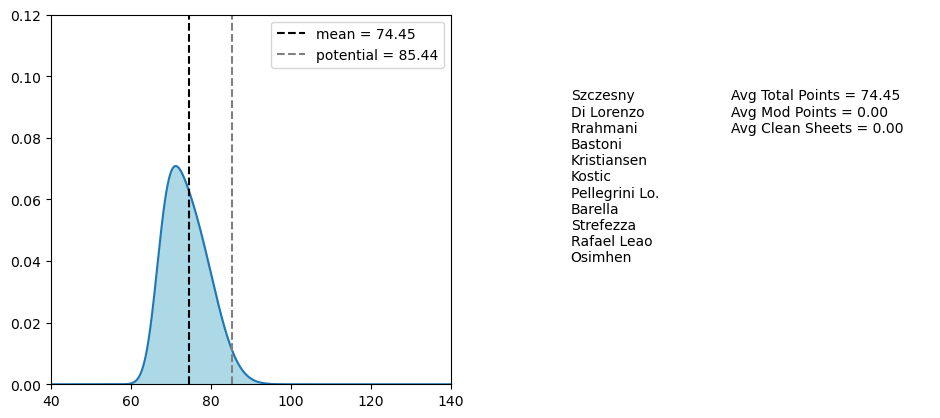

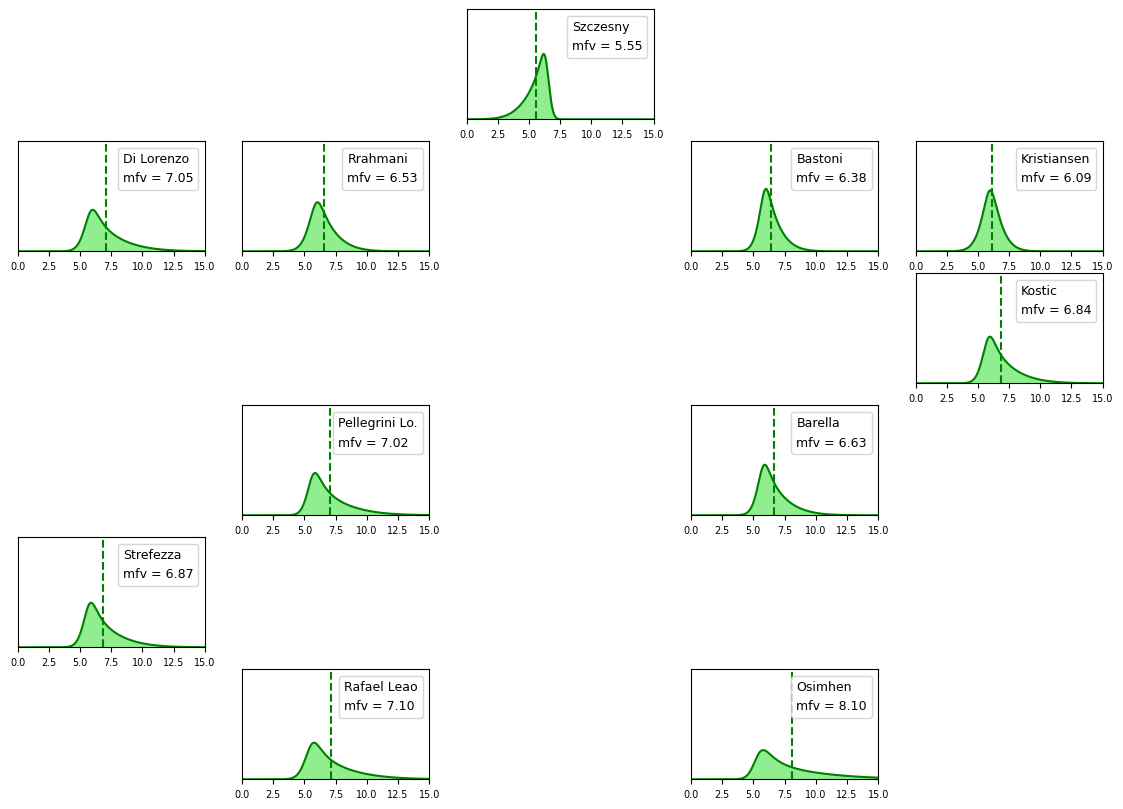

In [10]:
squad = ['Szczesny',
        'Di Lorenzo',
        'Rrahmani',
        'Bastoni',
        'Kristiansen',
        'Kostic',
        'Pellegrini Lo.',
        'Barella',
        'Strefezza',
        'Rafael Leao',
        'Osimhen']

s = simulate_lineup(squad)

plot_lineup(squad, config_442)